___
# <center> Import Python Libraries

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import concurrent.futures
import requests
import re
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import seaborn as sns
import klib
import requests
import scipy.stats
from scipy import stats
from scipy.stats import f_oneway,bartlett,kruskal,levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

___
## <center> Webscrapping Our Data Using BeautifulSoup
<center> Using Carsguide.com.au to webscrappe car price and associatted features.
    
___

In [168]:
# Scraping accross multiples pages via toggle menu each page url "offset" ascends in multiples of 13
loop = [x for x in range(14940) if x%13==0] # creating a multple of 13 list 
base_url = 'https://www.carsguide.com.au/buy-a-car/all-used/vic/all-locations/all-bodytypes/all-makes/?doors=%5B2%2C5%5D&seats=%7B%2C5%5D&distanceFromMe=Sunshine%2CVIC&searchOffset=13&searchLimit=13'
pages = requests.get(base_url)
soup = BeautifulSoup(pages.text,'lxml')


In [169]:
# looping through list in order to append each pages url to the new_urls_list
new_urls_list = []
for number in loop:
    new_urls_list.append(base_url.split('set=')[0]+'set='+str(number)+'&searchLimit=13')

# Diving deeper into the individual advertisment requires scraping those links per page
car_link_list = []
for new in new_urls_list: 
    link_pages = requests.get(new)
    link_soup = BeautifulSoup(link_pages.text,'lxml')
    for link in link_soup.find_all('a', attrs={'class': "carListing carListing-slideBtn"}): # Scrapping link
        car_link_list.append('https://www.carsguide.com.au/'+link.get('href')) # Appending each individual add link

In [170]:
# Multiprocessing runs faster as there are over 15000 links to scrape
listing = []
def transform(final_link):
    web_page = requests.get(final_link)
    web_soup = BeautifulSoup(web_page.text,"lxml")
    details = [x.get_text() for x in web_soup.find_all('table',{'class':"details-page-tab-table more-details clearfix"})]
    listing.append(details)
    return

with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(transform,car_link_list)

___
## <center> Saving our Data to Avoid Scraping Again


In [ ]:
# Saving our data
df = pd.DataFrame(listing)
#df.to_csv('CarSales_WebScrape.csv',index=False)

___
## <center> New Car Web-Scrape
___

In [ ]:
# Scraping accross multiples pages via toggle menu each page url "offset" ascends in multiples of 13
looping = [x for x in range(3099 ) if x%13==0] # creating a multple of 13 list 
new_base_url = 'https://www.carsguide.com.au/buy-a-car/all-new/all-states/all-locations/all-bodytypes/all-makes/?priceFrom=25000&priceTo=40000&bodyTypes=Commercial%2CConvertible%2CCoupe%2CHatchback%2CSedan%2CSUV%2CWagon&distanceFromMe=Sunshine%2CVIC&searchOffset=13&searchLimit=13'
new_pages = requests.get(new_base_url)
new_soup = BeautifulSoup(new_pages.text,'lxml')

# looping through list in order to append each pages url to the new_urls_list
newCar_urls_list = []
for number in looping:
    newCar_urls_list.append(new_base_url.split('set=')[0]+'set='+str(number)+'&searchLimit=13')
    

# Diving deeper into the individual advertisment requires scraping those links per page
new_car_link_list = []
for new in newCar_urls_list: 
    link_pages = requests.get(new)
    link_soup = BeautifulSoup(link_pages.text,'lxml')
    for link in link_soup.find_all('a', attrs={'class': "carListing carListing-slideBtn"}): # Scrapping link
        new_car_link_list.append('https://www.carsguide.com.au/'+link.get('href')) # Appending each individual add link
        
# Multiprocessing runs faster as there are over 3,000 links to scrape
preownedlisting = []
def transform(final_link):
    web_page = requests.get(final_link)
    web_soup = BeautifulSoup(web_page.text,"lxml")
    details = [x.get_text() for x in web_soup.find_all('table',{'class':"details-page-tab-table more-details clearfix"})]
    preownedlisting.append(details)
    return

with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(transform,new_car_link_list)
    
new_df = pd.DataFrame(preownedlisting)
#new_df.to_csv('NewCarSales_Web.csv',index=False)        

___
## <center> Reading in our Saved CSV Files
    
___

In [2]:
# Reading in our saved dataframe, renaming our column and viewing the first 5 rows
df = pd.read_csv('CarSales_WebScrape.csv')
df.rename(columns= {'0':'Details'}, inplace = True)

newCar_df = pd.read_csv('NewCarSales_Web.csv')
newCar_df.rename(columns= {'0':'Details'}, inplace = True)

___
### <center> Concatinating our Used and Preowned Datasets

___

In [3]:
df = pd.concat([df,newCar_df], ignore_index=True)
df.head(5)

,Details
0,"\n\nPrice\n$15,500 \n\n\n..."
1,"\n\nPrice\n$6,499 Calcu..."
2,"\n\nPrice\n$9,000 \n\n\nV..."
3,"\n\nPrice\n$35,990 Calc..."
4,"\n\nPrice\n$16,490 Calc..."


___
## <center> Data Cleaning and Wrangling
<center> We have webscarpped html table data as a single string and as a result we will encounter numerous syntax issues that will need to be cleaned.
    
___    
    
<center> The function below takes in five variables namely, the dataframe we are working with, the col we want to extract data from, the split_on/second_split variable which takes in a string we will split on, and the column_name variable which is what our new column will be named.
    
___    

In [4]:
#Creating a function to clean our data and create new columns
def clean(df,col,split_on,second_split,column_name):
    df[column_name] = df[col].str.split(split_on).str[1].str.strip()
    df[column_name] = df[column_name].str.split(second_split).str[0].str.strip()
    
clean(df,'Details','Price','Cal','Price') #Creating Price column
df['Price'] = df['Price'].str.split('\n').str[0].str.strip()

clean(df,'Details','Vehicle','Seller','Vehicle') #Creating Vehicle column

clean(df,'Details','Body type','Doors','Doors') #Creating Doors column
clean(df,'Details','Doors','Seats','Seats') #Creating Seats column

clean(df,'Details','ext / int','Reg','Colour') #Creating Colour column
clean(df,'Details','Kilometres','Colour','Kilometres') #Creating Kilometres column

clean(df,'Details','Body type',',','Body') #Creating Body column
df['Body'] = df['Body'].str.split('\n').str[0].str.strip()

clean(df,'Details','Transmission','Engine','Transmission') #Creating Transmission column

clean(df,'Details','Drive type','Fuel type','Drive') #Creating Drive column
clean(df,'Details','Fuel type','Fuel','Fuel_type') #Creating Fuel_type column

clean(df,'Details','Engine','Drive','Engine') #Creating Engine column
df['Engine'] = pd.to_numeric(df['Engine'].str.split(',').str[1].str.strip().str.split('L').str[0].str.strip(),errors='coerce')

clean(df,'Details','consumption','Kilometres','Fuel_consumption') #Creating Fuel_consumption column 

df.head(2)

,Details,Price,Vehicle,Doors,Seats,Colour,Kilometres,Body,Transmission,Drive,Fuel_type,Engine,Fuel_consumption
0,"\n\nPrice\n$15,500 \n\n\n...","$15,500",2016 Hyundai I40 Active Tourer VF4 Series II,"Wagon, 4",", 5",White / Dark grey,"105,000 km\n\n\nCondition\nUsed",Wagon,Automatic,Front,Unleaded,2.0,7.5 L / 100 km
1,"\n\nPrice\n$6,499 Calcu...","$6,499",2005 Holden Astra CD AH MY06,"Hatchback, 5",", 5",Silver / -,"174,681 km",Hatchback,Automatic,Front,Unleaded,1.8,8.2 L / 100 km


___
## <center> Replace Punctuation or Syntax issues using Regex
    
<center> Our columns still contain numerous syntax issues that need to be cleaned.
    
___
<center> The function is a syntax replacing function that takes in three variables namely, the column we want to perform our operation on and the syntax error we want to replace with just an empty string
    
___

In [5]:
# Creating a function to replace any punctuation or syntax issues using regex
def replacing(col,syntax,d=''):
    df[col] = df[col].str.replace(syntax, d, regex=True)
    
# We want to drop the dollar sign and comma so we can change this data type into an integer
replacing(r'Price','$') 
replacing(r'Price',',')

# We want to drop the km and comma so we can change this data type into an integer
replacing(r'Kilometres','km')
replacing(r'Kilometres',',')

replacing(r'Seats',',')
replacing(r'Fuel_consumption','L / 100 km')

df = df.replace(r'-',np.nan)

df.head(2)

,Details,Price,Vehicle,Doors,Seats,Colour,Kilometres,Body,Transmission,Drive,Fuel_type,Engine,Fuel_consumption
0,"\n\nPrice\n$15,500 \n\n\n...",15500,2016 Hyundai I40 Active Tourer VF4 Series II,"Wagon, 4",5,White / Dark grey,105000 \n\n\nCondition\nUsed,Wagon,Automatic,Front,Unleaded,2.0,7.5
1,"\n\nPrice\n$6,499 Calcu...",6499,2005 Holden Astra CD AH MY06,"Hatchback, 5",5,Silver / -,174681,Hatchback,Automatic,Front,Unleaded,1.8,8.2


____
## <center> Extract Numeric Values and Coercing them into Numeric Columns

<center> The function below extracts numeric values, using regex, from the desired columns and coerces them into numeric data types.
    
___    
    

In [6]:
#Creating a function to extract numeric values from certain columns
def extracting_numbers(column_name):
    df[column_name] = pd.to_numeric(df[column_name].str.extract('([\d]+)',expand=False))
    
extracting_numbers('Price') # Extracting only the price
extracting_numbers('Fuel_consumption') # Extracting only the fuel consumption integer
extracting_numbers('Doors') # Allows us to drop the Body type and be left with the number of doors only
extracting_numbers('Seats') # Cleaning up any left over text
extracting_numbers('Kilometres') # Cleaning up any left over text
df['Kilometres'] = np.where((df['Kilometres'].isnull())&(df.index >14000), 1, df['Kilometres'])

df.head(2)

,Details,Price,Vehicle,Doors,Seats,Colour,Kilometres,Body,Transmission,Drive,Fuel_type,Engine,Fuel_consumption
0,"\n\nPrice\n$15,500 \n\n\n...",15500.0,2016 Hyundai I40 Active Tourer VF4 Series II,4,5.0,White / Dark grey,105000.0,Wagon,Automatic,Front,Unleaded,2.0,7.0
1,"\n\nPrice\n$6,499 Calcu...",6499.0,2005 Holden Astra CD AH MY06,5,5.0,Silver / -,174681.0,Hatchback,Automatic,Front,Unleaded,1.8,8.0


___
## <center> Creating model and Model Year Columns
    
___    

In [7]:
#creating model column using regex
df['Model'] = (df['Vehicle'].str.split('\d{4}').str[1]).str.split().str[:1].str.join(' ')

#creating model year column using regex
df['MYear'] = df['Vehicle'].str.extract('([\d]+)',expand = False).astype(int)

# Creating an Age column and shifting our data to be able to perform transformations and you cannot log/sqrt a negative
df['Age'] = 2021 - df['MYear'] +1

df.head(2)

,Details,Price,Vehicle,Doors,Seats,Colour,Kilometres,Body,Transmission,Drive,Fuel_type,Engine,Fuel_consumption,Model,MYear,Age
0,"\n\nPrice\n$15,500 \n\n\n...",15500.0,2016 Hyundai I40 Active Tourer VF4 Series II,4,5.0,White / Dark grey,105000.0,Wagon,Automatic,Front,Unleaded,2.0,7.0,Hyundai,2016,6
1,"\n\nPrice\n$6,499 Calcu...",6499.0,2005 Holden Astra CD AH MY06,5,5.0,Silver / -,174681.0,Hatchback,Automatic,Front,Unleaded,1.8,8.0,Holden,2005,17


___
## <center> Cleaning Colour Column
    
<center> Our colour column contains 766 unique values and we want this column to exhibit a lower cardinality with white, grey, and black being grouped as the most popular car colours and the remainder being grouped as other.
    
___

In [8]:
df['Colour'].value_counts().count()

896

___
## <center> Removing duplicated observations
    
<center> Ensuring we have not scraped duplicate entries or that duplicated car ads do not affect our model
    
___    

In [9]:
# Droping any duplicated observations
df = df.drop_duplicates()
df.reset_index(drop = True, inplace=True) # Resetting our Index


___
## <center> Ensuring our Data Types are Correct
___ 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17037 entries, 0 to 17036
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Details           17037 non-null  object 
 1   Price             16988 non-null  float64
 2   Vehicle           17037 non-null  object 
 3   Doors             17037 non-null  int64  
 4   Seats             16739 non-null  float64
 5   Colour            17037 non-null  object 
 6   Kilometres        16908 non-null  float64
 7   Body              17037 non-null  object 
 8   Transmission      16903 non-null  object 
 9   Drive             17037 non-null  object 
 10  Fuel_type         16737 non-null  object 
 11  Engine            16612 non-null  float64
 12  Fuel_consumption  16702 non-null  float64
 13  Model             17037 non-null  object 
 14  MYear             17037 non-null  int64  
 15  Age               17037 non-null  int64  
dtypes: float64(5), int64(3), object(8)
memor

___
## <center> Reordering our Dataframe Columns and Dropping Columns
<center> Having both Seats and Doors is redundant as common sense indicates a high correllation between the two. Additionlly, the body type of the car determines the number of seats and doors a car has. Therefore, the Body variable acts as a proxy for all three variables.
    
___    

In [36]:
car_df = df.iloc[:,[1,13,15,6,7,8,9,10,11,12,3,4]].copy()
car_df.head(5)

,Price,Model,Age,Kilometres,Body,Transmission,Drive,Fuel_type,Engine,Fuel_consumption,Doors,Seats
0,15500.0,Hyundai,6,105000.0,Wagon,Automatic,Front,Unleaded,2.0,7.0,4,5.0
1,6499.0,Holden,17,174681.0,Hatchback,Automatic,Front,Unleaded,1.8,8.0,5,5.0
2,9000.0,Volkswagen,13,173000.0,Sedan,Automatic,Front,Diesel,2.0,6.0,4,5.0
3,35990.0,Subaru,3,16631.0,SUV,Automatic,AWD,Unleaded,2.5,7.0,4,5.0
4,16490.0,Hyundai,10,106646.0,SUV,Automatic,Front,Unleaded,2.0,8.0,4,5.0


___
## <center> Rule of Thumb

<center> I normally drop rows that have 1% or 2% missing values in a dataset this size. Notably, we are dropping missing price as it is our dependent variable. We can see that Transmission, and Kilometres are missing less than 0.8% of data points. Additionaly, there is strong multicolinearity between Kilometres and Age and as a result dropping the missing values in Kilometres does not affect our data as this column is likely to be dropped. Additionally, we see strong interconnectiveness between the missing values in Fuel_type, Engine, Seats, and Fuel_consumption indicating a threshold of missing values exceeding 4 columns for a number of these observations. 

___

Price               0.002876
Model               0.000000
Age                 0.000000
Kilometres          0.007572
Body                0.000000
Transmission        0.007865
Drive               0.000000
Fuel_type           0.017609
Engine              0.024946
Fuel_consumption    0.019663
Doors               0.000000
Seats               0.017491
dtype: float64


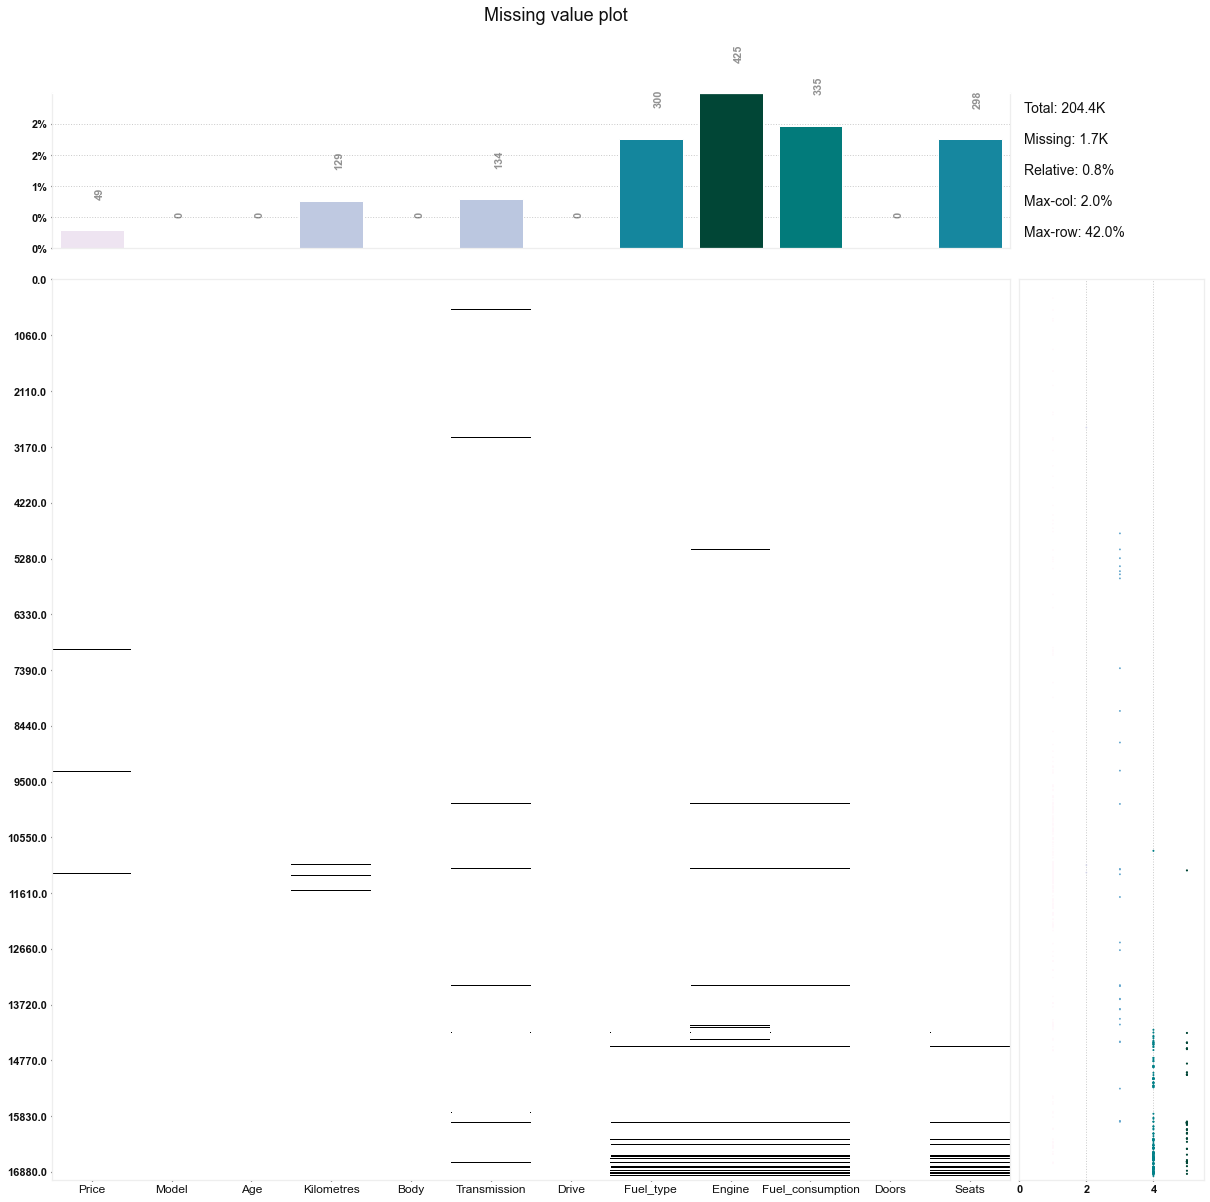

In [37]:
# Looking at the missing values contained in our dataframe
klib.missingval_plot(car_df)
print(car_df.isnull().sum()/car_df.shape[0])

___
## <center> Dropping Missing Values

In [38]:
car_df.dropna(inplace = True)
car_df = car_df.reset_index(drop = True) # Resetting our Index

# Looking at the missing values contained in our dataframe
klib.missingval_plot(car_df)
print(car_df.isnull().sum()/car_df.shape[0])

No missing values found in the dataset.
Price               0.0
Model               0.0
Age                 0.0
Kilometres          0.0
Body                0.0
Transmission        0.0
Drive               0.0
Fuel_type           0.0
Engine              0.0
Fuel_consumption    0.0
Doors               0.0
Seats               0.0
dtype: float64


___
## <center> Exploratory Data Analysis

We will start with our quantitative independent variables:
- **Univariate Analysis** (Shape, Distribution, skewness, Transformation)
- **Bivaraite Analysis** (Correlation with Price)

___
## <center> Price Statistical Plots

<center> We expect any dataset containg a price variable to be very right skewed and our case is no exception with luxury car prices in excess of $100,000

___

#### <center> Skewness statistic (5.08) indicates a heavy right skew.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='Price', ylabel='Density'>

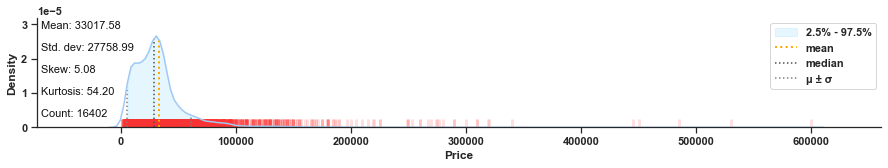

In [39]:
klib.dist_plot(car_df['Price'])

In [40]:
def boxplot(data,variable):
    sns.set_theme(style="ticks",palette="pastel")
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Draw boxplot
    sns.boxplot(x = variable, data = data)
    
    # Despine
    sns.despine(offset=10,right=True,
                bottom=False)

    # Add gridlines
    ax.xaxis.grid(True)

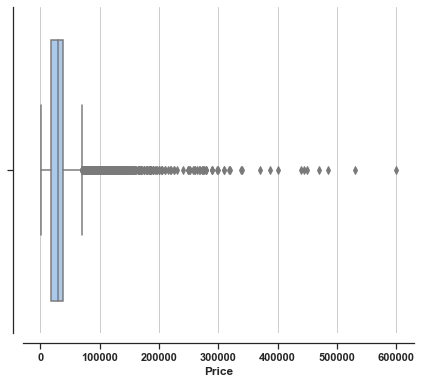

In [41]:
boxplot(car_df,'Price')

___
### <center> Based on a Canstar Blue survey the Average Car Cost in Victoria is between \$33,327 - \\$41,327

<center> We are not interested in predicting "Luxury" brand cars as such we will be using \$37,000 as our Price threshold.
    
___
    
#### <center> Our plot indicates a reduction in skewness and right tailed outliers towards a more moderate right skew      

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='Price', ylabel='Density'>

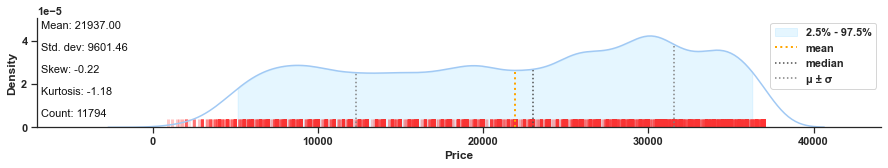

In [42]:
car_data = car_df[car_df['Price']<37000].copy()
klib.dist_plot(car_data['Price'])

___
### <center> We can see the removal of most of our Price Ouliers 

___    

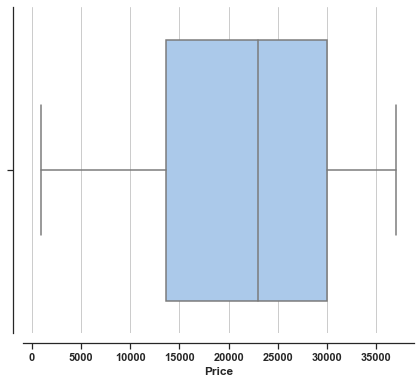

In [43]:
boxplot(car_data,'Price')

___
## <center> Age Statistical Plots
    
<center> Our Dataset contains some fairly old cars that are in excess of 30 years old that will be treated as outliers
    
___

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='Age', ylabel='Density'>

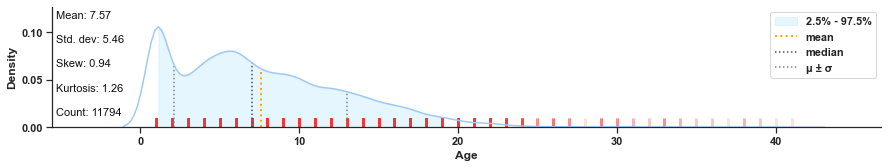

In [44]:
klib.dist_plot(car_data['Age'])

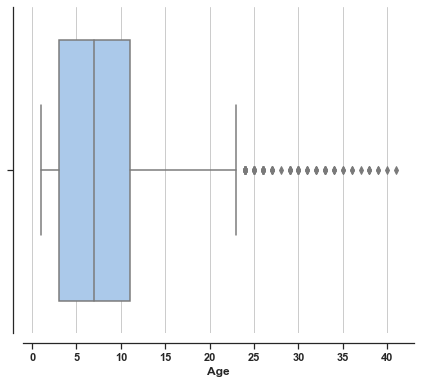

In [45]:
boxplot(car_data, 'Age')

___
#### <center> Our plot indicates a reduction in skewness and right tailed outliers towards a more moderate right skew 
    
___

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='Age', ylabel='Density'>

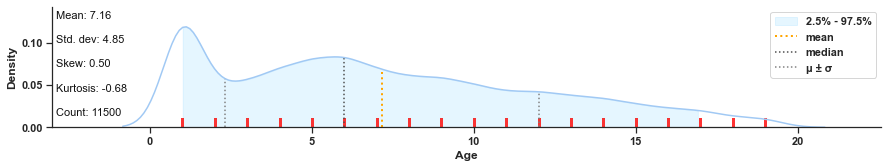

In [46]:
car_price_df = car_data[car_data['Age']<20].copy()
klib.dist_plot(car_price_df['Age'])

___
### <center> We can see the removal of most of our Age Ouliers 
___    

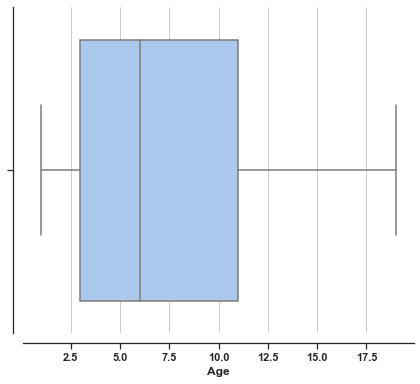

In [47]:
boxplot(car_price_df, 'Age')

___
## <center> Kilometres Statistical Plots
    
<center> Our Kilometres Variable contains values in excess of 320,000km that will be treated as outliers
    
___

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='Kilometres', ylabel='Density'>

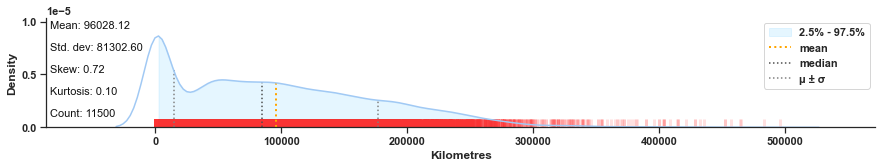

In [48]:
klib.dist_plot(car_price_df['Kilometres'])

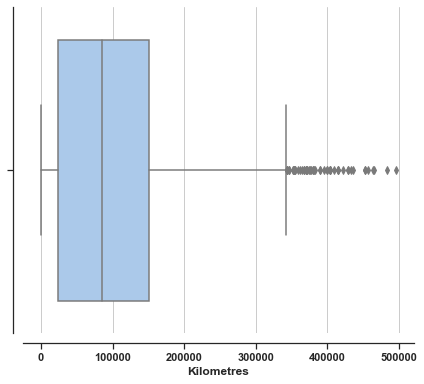

In [49]:
boxplot(car_price_df, 'Kilometres')

___
### <center> We can see the removal of most of our Ouliers 
___    

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='Kilometres', ylabel='Density'>

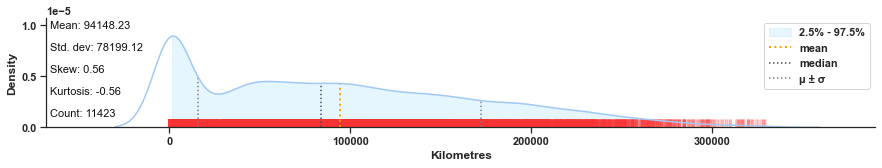

In [50]:
car_pricing = car_price_df[car_price_df['Kilometres']<330000].copy()
klib.dist_plot(car_pricing['Kilometres'])

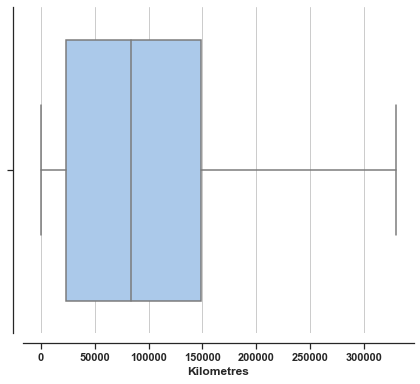

In [51]:
boxplot(car_pricing, 'Kilometres')

___
## <center> Bivaraite Analysis
    
<center> We expect too see high correlation between Age and Kilometers as the older the car the more it has been driven

<AxesSubplot:>

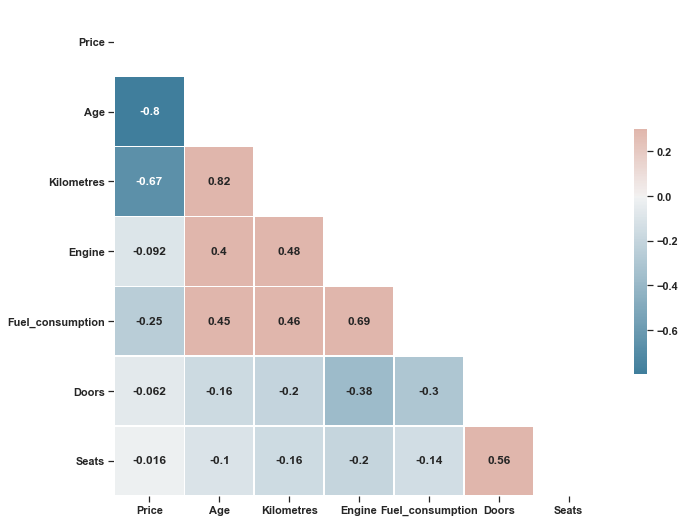

In [52]:
# Compute the correlation matrix
corr = car_pricing.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           annot=True, ax=ax)

___
## <center> Feature Engineering and Dropping Features
<center> Age is our only variable that possess a strong correlation with Price. Notably, Kilometeres is highly correlated with Age which will require us to drop this variable. Additionally, Door, Seat, and Engine could be seen as as discrete categorical variables. Additionally, Seats and Doors have no discernable correlation with price whatsoever and will be dropped as well. However, we want to reduce the dimetionality of our dataset by creating a new variable. An Engine Durability feature which is a function of both Fuel_consumption and Engine.
    
___
    

In [53]:
car_pricing['Engine_Durability'] = np.square(car_pricing['Fuel_consumption']+0.1)/(car_pricing['Engine'])*car_pricing['Doors']
strong_features = car_pricing.drop(columns=['Fuel_consumption','Engine','Doors','Seats','Kilometres'])

<AxesSubplot:>

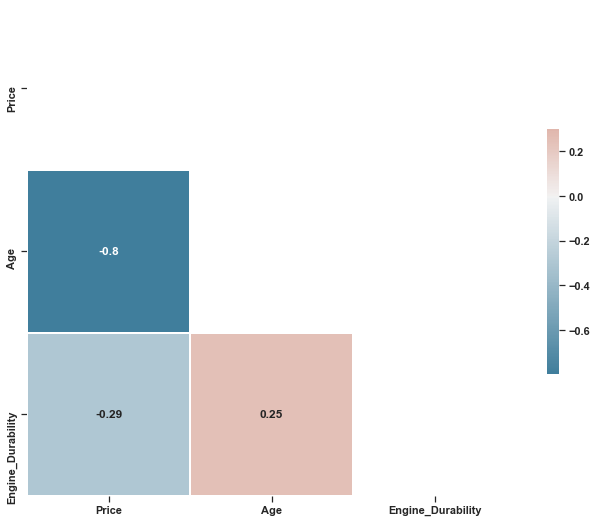

In [54]:
# Compute the correlation matrix
corr = strong_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           annot=True, ax=ax)

___
### <center> Multicolinearity
<center> Detecting Multicolinearity with the Variance Inflation Factor(VIF).
    
___

In [97]:
def vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = strong_features[['Price','Engine_Durability','Age']]

vif(X)

,variables,VIF
0,Price,3.325919
1,Engine_Durability,6.733017
2,Age,3.351908



___
## <center> Pairplot
    
___  
    
<center> Price and Age seem to have a slight quadratic relationship and the sharp cut-off is due to age having a lower bound of zero.
    
    
___

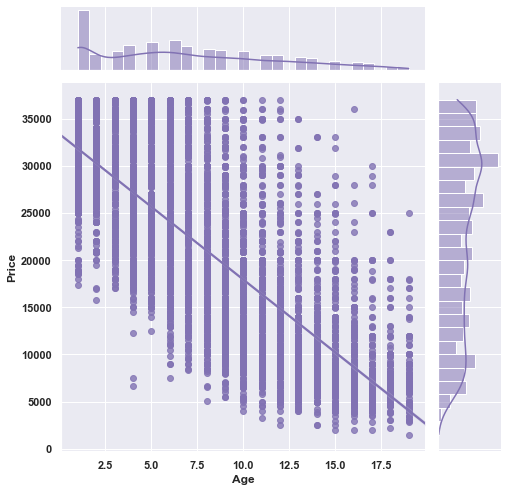

In [58]:
sns.set_theme(style="darkgrid")

sns.jointplot(x="Age", y='Price', data= strong_features,
                  kind="reg", truncate=False,
                  color="m", height=7)

___
## <center> Exploratory Data Analysis

Categorical independent variables:
- **Univariate Analysis** 
- **Bivaraite Analysis** (Statistical Test: ANOVA & Independent sample T-Test)
 

GridSpec(6, 5)

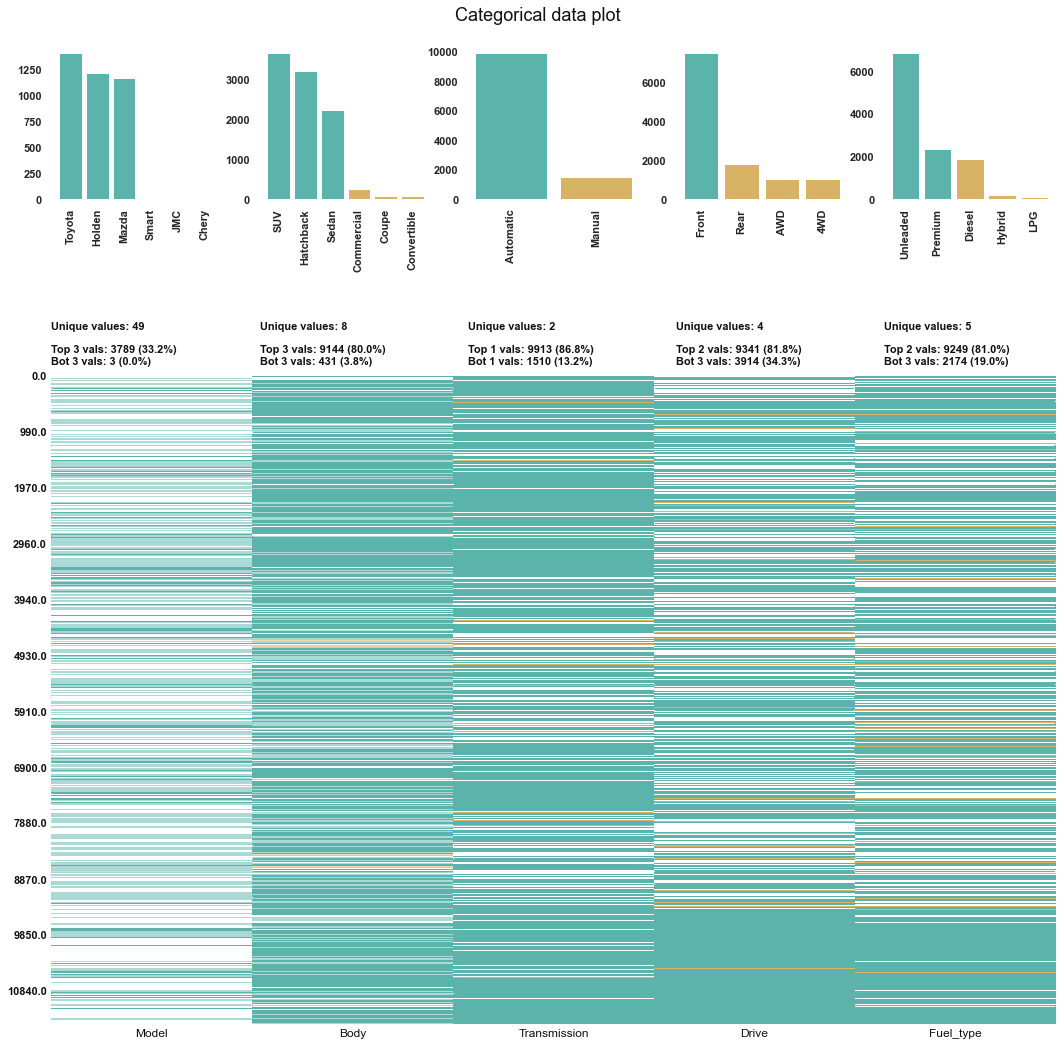

In [59]:
klib.cat_plot(strong_features)

___
### <center> Investigating cardinality

<center> We refer to the number of unique entries of a categorical variable as the cardinality of that categorical variable.
    
___

In [60]:
# All categorical columns
object_cols = [col for col in strong_features.columns if strong_features[col].dtype == 'object']

# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: strong_features[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
print(sorted(d.items(), key=lambda x: x[1],reverse=True))

# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if strong_features[col].nunique() <= 8]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('\nCategorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that require Feature engineering or need to be dropped from the dataset:',high_cardinality_cols)

[('Model', 49), ('Body', 8), ('Fuel_type', 5), ('Drive', 4), ('Transmission', 2)]

Categorical columns that will be one-hot encoded: ['Body', 'Transmission', 'Drive', 'Fuel_type']

Categorical columns that require Feature engineering or need to be dropped from the dataset: ['Model']


___
## <center> Categorical Feature Engineering

___
    
<center> There are 50 unique models that we will group according to model similairty and price range into a lower cardinality of 8.
    
___

In [61]:
model_list = pd.Series(strong_features.Model.value_counts().head(27)).index.to_list()

new_filtered_car = strong_features[strong_features['Model'].isin(model_list)].copy()
new_filtered_car.reset_index(drop = True, inplace=True) # Resetting our Index

In [62]:
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='Mini')|(new_filtered_car['Model']=='Mazda')|(new_filtered_car['Model']=='Audi')|(new_filtered_car['Model']=='Kia'), 'Kia/Audi/Mazda/Mini',new_filtered_car['Model'])
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='Land')|(new_filtered_car['Model']=='Suzuki')|(new_filtered_car['Model']=='Volkswagen'), 'Suzuki/Land/Volkswagen',new_filtered_car['Model'])
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='Toyota')|(new_filtered_car['Model']=='Subaru')|(new_filtered_car['Model']=='Renault')|(new_filtered_car['Model']=='Nissan'), 'Renault/Nissan/Subaru/Toyota',new_filtered_car['Model'])
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='Mitsubishi')|(new_filtered_car['Model']=='Hyundai')|(new_filtered_car['Model']=='Mercedes-Benz'), 'Mitsubishi/Hyundai/Mercedes-Benz',new_filtered_car['Model'])
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='Holden')|(new_filtered_car['Model']=='Peugeot')|(new_filtered_car['Model']=='Fiat'), 'Holden/Peugeot/Fiat',new_filtered_car['Model'])
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='MG')|(new_filtered_car['Model']=='Isuzu'), 'Isuzu/MG',new_filtered_car['Model'])
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='Lexus')|(new_filtered_car['Model']=='BMW'), 'Lexus/BMW',new_filtered_car['Model'])
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='Jeep')|(new_filtered_car['Model']=='Skoda'), 'Jeep/Skoda',new_filtered_car['Model'])
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='Honda')|(new_filtered_car['Model']=='Volvo')|(new_filtered_car['Model']=='Ford'), 'Honda/Volvo/Ford',new_filtered_car['Model'])
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='LDV')|(new_filtered_car['Model']=='GWM'), 'LDV/GWM',new_filtered_car['Model'])
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='Kia/Audi/Mazda/Mini')|(new_filtered_car['Model']=='Suzuki/Land/Volkswagen'), 'Kia/Audi/Maz/Mini/Suz/Land/VW',new_filtered_car['Model'])
new_filtered_car['Model']= np.where((new_filtered_car['Model']=='Renault/Nissan/Subaru/Toyota')|(new_filtered_car['Model']=='Mitsubishi/Hyundai/Mercedes-Benz'), 'Mit/Hyun/Benz/Ren/Nis/Sub/Toy',new_filtered_car['Model'])

___
### <center> Body Variable
    
<center> Similar body types will be grouped to lower cardinality
    
___

In [63]:
def grouping_similar(Body,old_type,rename):
    new_filtered_car[Body] = np.where(new_filtered_car[Body]==old_type,rename,new_filtered_car[Body])

grouping_similar('Body','Ute / Tray','Commercial/Ute-Tray/SUV')

grouping_similar('Body','Commercial','Commercial/Ute-Tray/SUV')

grouping_similar('Body','SUV','Commercial/Ute-Tray/SUV')

grouping_similar('Body','Coupe','Coupe/Convertible')

grouping_similar('Body','Convertible','Coupe/Convertible')


___
### <center> Drive Variable
    
<center> Similar Drive types will be grouped to lower cardinality
    
___

In [64]:
grouping_similar('Drive','Front','4WD/Front')
grouping_similar('Drive','4WD','4WD/Front')

___
### <center> Fuel Type Variable
    
<center> Similar Fuel Typ will be grouped to lower cardinality
    
___

In [65]:
grouping_similar('Fuel_type','Diesel','Diesel/Premium')
grouping_similar('Fuel_type','Premium','Diesel/Premium')

GridSpec(6, 5)

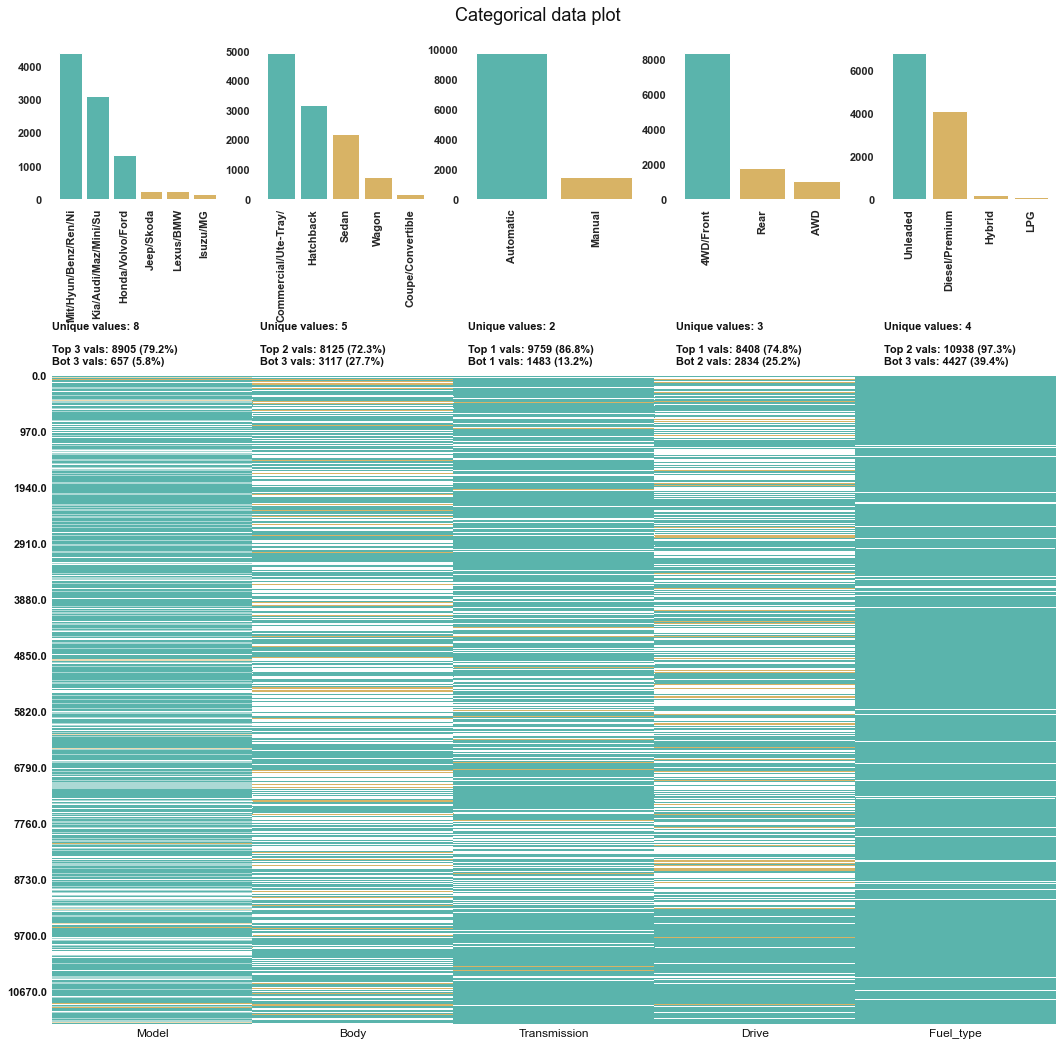

In [66]:
klib.cat_plot(new_filtered_car)

___
## <center> Creating A Statistical Testing Class


<center> Is there a statistically significant difference between the mean price of cars and their associated categorical variables at a significance level of 95%?
    
___
<center> To test our hypothesis we must first determine whether our categorical variables have a balanced design, their residuals are approximately normal, and they exhibit Homogeneity of variances within their group. Notably, due to violations of normality and homoscedasticity, the kruskal-Wallis test is used as opposed to an ANOVA test. Finally, the Tukey’s Test allows us to make pairwise comparisons between the means of each group while controlling for the family-wise error rate.
    
___    

In [67]:
class statistical_testing:
        
    def __init__(self, dataframe, cat_var, cont_var):
        self.dataframe = dataframe
        self.cat_var = cat_var
        self.cont_var = cont_var

    def price_differential(self, bootstraped = None):
        """Grouping our dataframe by our select variable and creating mean price and count variables. Finally sorting by mean price in descending order."""
        if bootstraped == None: 
            price = self.dataframe.groupby(self.cat_var).agg({self.cont_var:["mean","count"]})
            return price.Price.sort_values(by = ['mean'],ascending = False).style.format('{0:,.0f}')
        else:
            df = self.stratified_sample_df()
            price = df.groupby(self.cat_var).agg({self.cont_var:["mean","count"]})
            print(f'{self.cat_var} Stratified Bootsraped With Replacement')
            return price.Price.sort_values(by = ['mean'],ascending = False).style.format('{0:,.0f}')
            
    def stratified_sample_df(self):
        np.random.seed(42)
        """Using a stratified bootstrapped sample to Group our dataframe by our selected variable and creating mean price and count variables."""
        n = int((self.dataframe[self.cat_var].value_counts().max()+self.dataframe[self.cat_var].value_counts().min())/2)
        df_ = self.dataframe.groupby(self.cat_var).apply(lambda x: x.sample(n,replace=True))
        df_.index = df_.index.droplevel(0)
        return df_
        

    def equal_var_plot(self):
        """Display seaborn boxplot using Price as y-axis and your select variable as the x-axis"""
        sns.set_theme(style="ticks",palette="pastel")
        df = self.stratified_sample_df()
        fig, ax = plt.subplots(figsize=(7, 6))
        sns.boxplot(x = self.cat_var,y = self.cont_var,data=df)# Draw boxplot
        sns.despine(offset=10,right=True,
                bottom=False)# Despine
        ax.xaxis.grid(True)# Add gridlines
        plt.xticks(rotation=90)

    def residual_distribution(self):
        """Shapiro-Wilk test to determine normality of data as well as QQ plots for the selected categorical variable."""
        df = self.stratified_sample_df()
        model_df = df.select_dtypes(include=['object',float]).copy()
        normality = model_df.sample(n=4999, replace=False, random_state=1)
        model_norm = ols(f'{self.cont_var} ~ C({self.cat_var})', data = normality).fit()
        w, pvalue = stats.shapiro(model_norm.resid)
        if pvalue <=0.05:
            print(f'Using the Shapiro-Wilk test.\n\nThe pvalue ({pvalue}) is significant allowing us to conclude the data is likely drawn from a non-normal distribution.\n\nAdditionally, the QQ plots below show a clear divergence from the diagonal line.')
              
        unique_features = df[self.cat_var].unique()
                  
        if int(len(unique_features))>=4:
            a = 2 # number of rows
            b = int(np.round(len(unique_features)/1.9)) # number of columns
            c = 1  # initialize plot counter
            d = b * 8
            
            fig = plt.figure(figsize=(d,12))

            for feature in unique_features:
                plt.subplot(a, b, c)
                stats.probplot(df[df[self.cat_var] == feature][self.cont_var], dist="norm", plot=plt)
                plt.title(f"{feature} - Value Count: {len(df[df[self.cat_var] == feature][self.cont_var])}")
                c +=1
        else:
            a = 1 # number of rows
            b = int(len(unique_features)) # number of columns
            c = 1  # initialize plot counter
            d = b * 10

            fig = plt.figure(figsize=(d,12))
            for feature in unique_features:
                plt.subplot(1, int(len(unique_features)), c)
                stats.probplot(df[df[self.cat_var] == feature][self.cont_var], dist="norm", plot=plt)
                plt.title(f"{feature} - Value Count: {len(df[df[self.cat_var] == feature][self.cont_var])}")
                c +=1
    
    def Homogenity_of_Variance(self):  
        """Test Homogenity of variance using the levene test and display selected variable boxplots to visually illustrate variance of means."""
        df = self.stratified_sample_df()
        element_dictionary = {}
        variables = []
        unique = df[self.cat_var].unique()
        for element in unique:
            element_dictionary[element] = df[df[self.cat_var]==element][self.cont_var].values
            variables.append(element)
            
        if len(element_dictionary.keys()) == 2:
            w, pvalue = levene(element_dictionary[variables[0]],element_dictionary[variables[1]])
            if pvalue <=0.05:
                print(f'Using the Levene test to check the Homogeneity of variances.\n\nThe pvalue ({pvalue}) is significant allowing us to conclude that types of {self.cat_var} have unequal variance')
            else: 
                print(f'Using the Levene test to check the Homogeneity of variances.\n\nThe pvalue ({pvalue}) is not significant allowing us to conclude that types of {self.cat_var} have equal variance')
        elif len(element_dictionary.keys()) == 3:
            w, pvalue = levene(element_dictionary[variables[0]],element_dictionary[variables[1]],element_dictionary[variables[2]])
            if pvalue <=0.05:
                print(f'Using the Levene test to check the Homogeneity of variances.\n\nThe pvalue ({pvalue}) is significant allowing us to conclude that types of {self.cat_var} have unequal variance')
        elif len(element_dictionary.keys()) == 4:
            w, pvalue = levene(element_dictionary[variables[0]],element_dictionary[variables[1]],element_dictionary[variables[2]],element_dictionary[variables[3]])
            if pvalue <=0.05:
                print(f'Using the Levene test to check the Homogeneity of variances.\n\nThe pvalue ({pvalue}) is significant allowing us to conclude that types of {self.cat_var} have unequal variance')
        elif len(element_dictionary.keys()) == 5:
            w, pvalue = levene(element_dictionary[variables[0]],element_dictionary[variables[1]],element_dictionary[variables[2]],element_dictionary[variables[3]],element_dictionary[variables[4]])
            if pvalue <=0.05:
                print(f'Using the Levene test to check the Homogeneity of variances.\n\nThe pvalue ({pvalue}) is significant allowing us to conclude that types of {self.cat_var} have unequal variance')
        elif len(element_dictionary.keys()) == 8:
            w, pvalue = levene(element_dictionary[variables[0]],element_dictionary[variables[1]],element_dictionary[variables[2]],element_dictionary[variables[3]],element_dictionary[variables[4]],element_dictionary[variables[5]],element_dictionary[variables[6]],element_dictionary[variables[7]])
            if pvalue <=0.05:
                print(f'Using the Levene test to check the Homogeneity of variances.\n\nThe pvalue ({pvalue}) is significant allowing us to conclude the type of {self.cat_var} have unequal variances')
        
        self.equal_var_plot()
        
        
    def tuskey(self):
        """Display the Tukey’s Test which allows us to make pairwise comparisons."""
        df = self.stratified_sample_df()
        unique = df[self.cat_var].unique()
        
        if len(unique) > 2:  
            self.tuskey = pairwise_tukeyhsd(endog=df[self.cont_var],
                          groups=df[self.cat_var],
                          alpha=0.05)
            print(self.tuskey.summary())   
            
            rejection_counter = Counter(self.tuskey.reject)
            summary = pd.DataFrame(self.tuskey.summary())
            new_df  = pd.DataFrame(summary.values[1:], columns= ['Group1','Group2',2,3,4,5,'Reject'],dtype = str)
            listed_fails = new_df[new_df['Reject']=='False']['Group1'].to_list()
            listed_fails1 = new_df[new_df['Reject']=='False']['Group2'].to_list()
            print(f'We fail to reject {rejection_counter[False]} and reject {rejection_counter[True]}')
            print(f'\nWe would thus conclude that there is a statistically significant difference\nbetween the {rejection_counter[True]} pairwise mean comparisons of {self.cat_var} type groups')
            if len(listed_fails)>=1:
                for index, x in enumerate(listed_fails):
                    print(f'\nThe pairwise mean comparisons of {listed_fails[index]} - {listed_fails1[index]} fail to be rejected')
       
    def kruskal(self): 
        """Display the Tukey’s Test which allows us to make pairwise comparisons as well as the Kruskal-Wallis test."""
        df = self.stratified_sample_df()
        element_dictionary = {}
        variables = []
        unique = df[self.cat_var].unique()
        for element in unique:
            element_dictionary[element] = df[df[self.cat_var]==element][self.cont_var].values
            variables.append(element)
            
        if len(element_dictionary.keys()) == 2:
            w, pvalue = kruskal(element_dictionary[variables[0]],element_dictionary[variables[1]])
            if pvalue <=0.05:
                print(f'The p-value obtained from Kruskal-Wallis analysis is significant {pvalue}\n\nWe reject the null hypothesis and conclude that there is a statistically significant difference among the mean price of {self.cat_var} types.')
        elif len(element_dictionary.keys()) == 3:
            w, pvalue = kruskal(element_dictionary[variables[0]],element_dictionary[variables[1]],element_dictionary[variables[2]])
            if pvalue <=0.05:
                print(f'The p-value obtained from Kruskal-Wallis analysis is significant {pvalue}\n\nWe reject the null hypothesis and conclude that there is a statistically significant difference among the mean price of {self.cat_var} types.')
        elif len(element_dictionary.keys()) == 4:
            w, pvalue = kruskal(element_dictionary[variables[0]],element_dictionary[variables[1]],element_dictionary[variables[2]],element_dictionary[variables[3]])
            if pvalue <=0.05:
                print(f'The p-value obtained from Kruskal-Wallis analysis is significant {pvalue}\n\nWe reject the null hypothesis and conclude that there is a statistically significant difference among the mean price of {self.cat_var} types.')
        elif len(element_dictionary.keys()) == 5:
            w, pvalue = kruskal(element_dictionary[variables[0]],element_dictionary[variables[1]],element_dictionary[variables[2]],element_dictionary[variables[3]],element_dictionary[variables[4]])
            if pvalue <=0.05:
                print(f'The p-value obtained from Kruskal-Wallis analysis is significant {pvalue}\n\nWe reject the null hypothesis and conclude that there is a statistically significant difference among the mean price of {self.cat_var} types.')
        elif len(element_dictionary.keys()) == 8:
            w, pvalue = kruskal(element_dictionary[variables[0]],element_dictionary[variables[1]],element_dictionary[variables[2]],element_dictionary[variables[3]],element_dictionary[variables[4]],element_dictionary[variables[5]],element_dictionary[variables[6]],element_dictionary[variables[7]])
            if pvalue <=0.05:
                print(f'The p-value obtained from Kruskal-Wallis analysis is significant {pvalue}\n\nWe reject the null hypothesis and conclude that there is a statistically significant difference among the mean price of {self.cat_var} types.')
      
        print()
        self.tuskey()
        
        
    def Anova(self):
        df = self.stratified_sample_df()
        unique = df[self.cat_var].unique()
        w,pvalue = stats.f_oneway(df[self.cont_var][df[self.cat_var] == unique[0]],
               df[self.cont_var][df[self.cat_var] == unique[1]])
        print(f'The p-value obtained from ANOVA analysis is significant {pvalue}\n\nWe reject the null hypothesis and conclude that there is a statistically significant difference among the mean price of {self.cat_var} types.')
        

___
## <center> Models
<center> Is there statistically significant difference between the mean price of different models at a significance level of 95%?

___
$$$$
**Null hypothesis:** Groups means are equal
$$$$
**Alternative hypothesis:** At least, one group mean is different from other groups
___
    
**Non-Parametric Test:** Kruskal-Wallis   
    
**Level of Significance:** 0.05
    
___
    
#### <center> At first instance groups mean prices differ
    
<center> Model groups exhibit an imbalance (Unbalanced Design) indicating a general loss of statistical power. We will be using a Bootstrapped dataset statified by our Models variable to ensure we obtain an equal balance.

___    

In [68]:
models_stat = statistical_testing(new_filtered_car,'Model','Price')
models_stat.price_differential()

,mean,count
Model,,
LDV/GWM,"31,771",349
Isuzu/MG,"30,662",167
Jeep/Skoda,"25,969",254
Kia/Audi/Maz/Mini/Suz/Land/VW,"24,098","3,139"
Mit/Hyun/Benz/Ren/Nis/Sub/Toy,"22,569","4,423"
Lexus/BMW,"20,586",236
Honda/Volvo/Ford,"19,474","1,343"
Holden/Peugeot/Fiat,"16,968","1,331"


In [69]:
models_stat.price_differential(bootstraped = True)

Model Stratified Bootsraped With Replacement


,mean,count
Model,,
LDV/GWM,"31,745","2,295"
Isuzu/MG,"30,776","2,295"
Jeep/Skoda,"25,928","2,295"
Kia/Audi/Maz/Mini/Suz/Land/VW,"24,079","2,295"
Mit/Hyun/Benz/Ren/Nis/Sub/Toy,"22,709","2,295"
Lexus/BMW,"20,320","2,295"
Honda/Volvo/Ford,"19,288","2,295"
Holden/Peugeot/Fiat,"16,958","2,295"


___
#### <center> Non-Normality of Our Data
    
___    

Using the Shapiro-Wilk test.

The pvalue (3.8938907572514184e-14) is significant allowing us to conclude the data is likely drawn from a non-normal distribution.

Additionally, the QQ plots below show a clear divergence from the diagonal line.


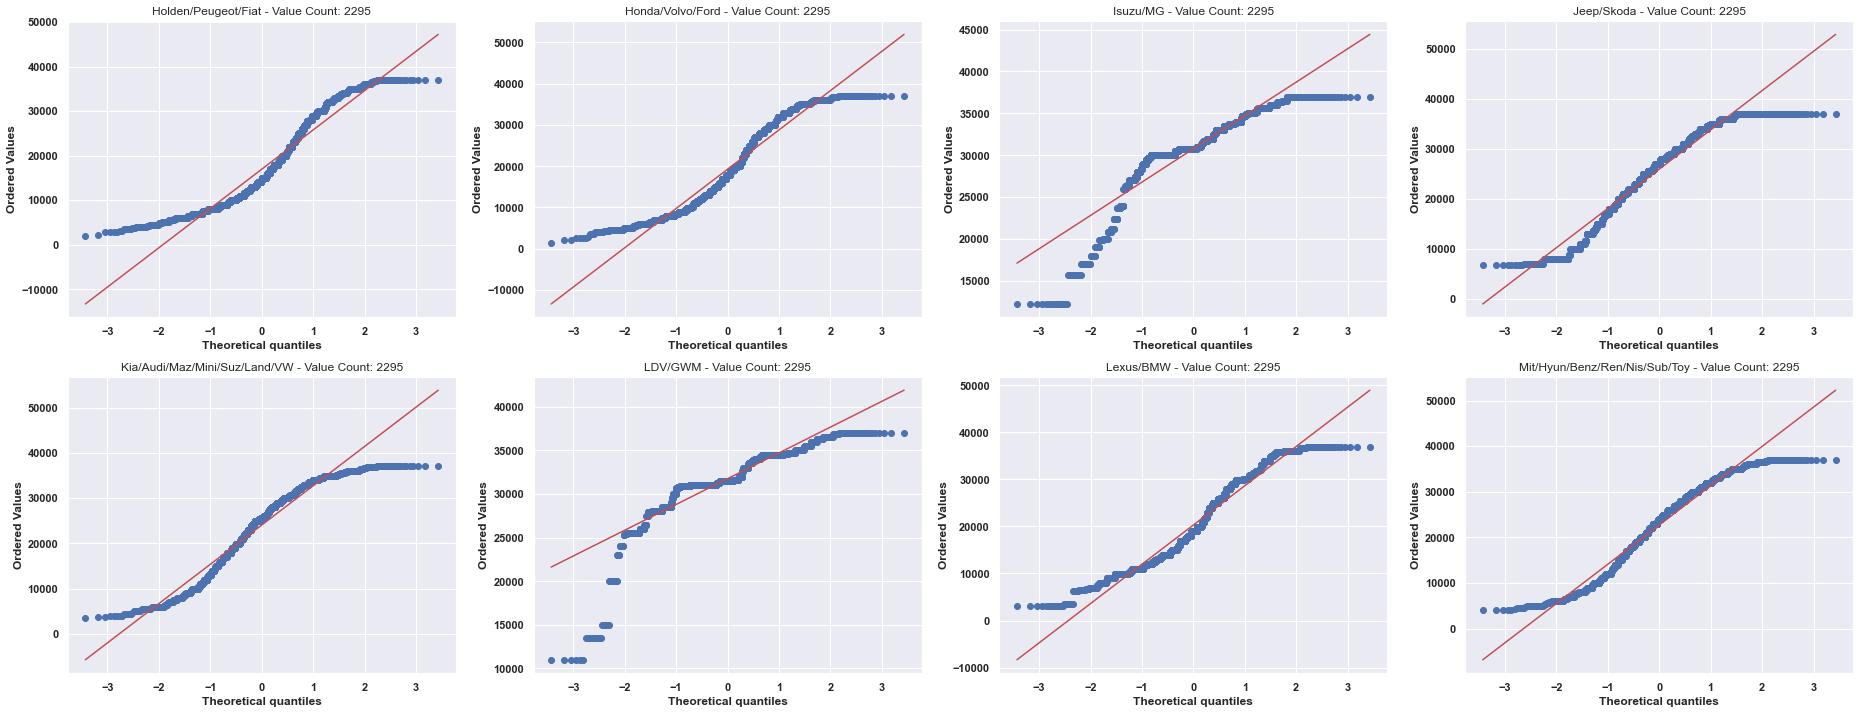

In [70]:
models_stat.residual_distribution()

___
#### <center> Homogenity of Variance Among Groups

<center> Is our assumption of Homoscedasticity violed?
    
___    

Using the Levene test to check the Homogeneity of variances.

The pvalue (0.0) is significant allowing us to conclude the type of Model have unequal variances


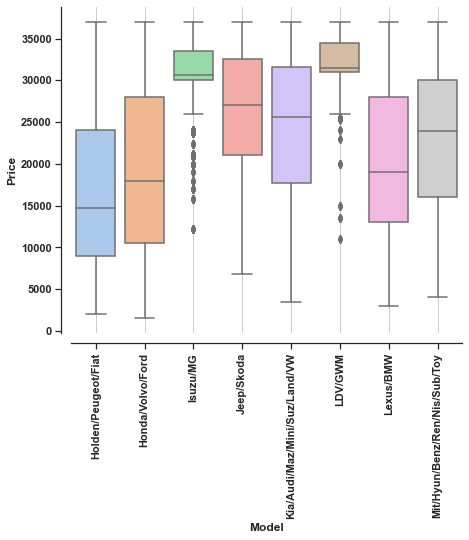

In [71]:
models_stat.Homogenity_of_Variance()

___
#### <center> Using the Kruskal-Wallis Test (Nonparametric) instead of a One-Way Anova as assumptions violated
    
___

In [72]:
models_stat.kruskal()

The p-value obtained from Kruskal-Wallis analysis is significant 0.0

We reject the null hypothesis and conclude that there is a statistically significant difference among the mean price of Model types.

                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                            
            group1                        group2              meandiff  p-adj    lower      upper    reject
-----------------------------------------------------------------------------------------------------------
          Holden/Peugeot/Fiat              Honda/Volvo/Ford   2329.8645 0.001   1619.2296  3040.4994   True
          Holden/Peugeot/Fiat                      Isuzu/MG  13817.7338 0.001  13107.0988 14528.3687   True
          Holden/Peugeot/Fiat                    Jeep/Skoda   8969.9316 0.001   8259.2967  9680.5665   True
          Holden/Peugeot/Fiat Kia/Audi/Maz/Mini/Suz/Land/VW     7120.98 0.001    6410.345  7831.6149   True
          Holden/Peugeot/Fiat           

___
## <center> Body
<center> Is there statistically significant difference between the mean price of different Body's at a significance level of 95%?

___
$$$$
**Null hypothesis:** Group means are equal
$$$$
**Alternative hypothesis:** At least, one group mean is different from other groups
___
    
**Non-Parametric Test:** Kruskal-Wallis   
    
**Level of Significance:** 0.05
    
___
    
#### <center> At first instance groups mean prices differ
    
<center> Body groups exhibit an imbalance (Unbalanced Design) indicating a general loss of statistical power. We will be using a Bootstrapped dataset statified by our Body variable to ensure we obtain an equal balance.
    
___    

In [73]:
body_stat = statistical_testing(new_filtered_car,'Body','Price')
body_stat.price_differential()

,mean,count
Body,,
Commercial/Ute-Tray/SUV,"25,657","4,949"
Wagon,"24,527",745
Coupe/Convertible,"21,880",165
Hatchback,"19,598","3,176"
Sedan,"18,469","2,207"


In [74]:
body_stat.price_differential(bootstraped=True)

Body Stratified Bootsraped With Replacement


,mean,count
Body,,
Commercial/Ute-Tray/SUV,"25,609","2,557"
Wagon,"24,694","2,557"
Coupe/Convertible,"21,850","2,557"
Hatchback,"19,446","2,557"
Sedan,"18,317","2,557"


___
#### <center> Non-Normality of Our Data
    
___    

Using the Shapiro-Wilk test.

The pvalue (1.4554294719451875e-28) is significant allowing us to conclude the data is likely drawn from a non-normal distribution.

Additionally, the QQ plots below show a clear divergence from the diagonal line.


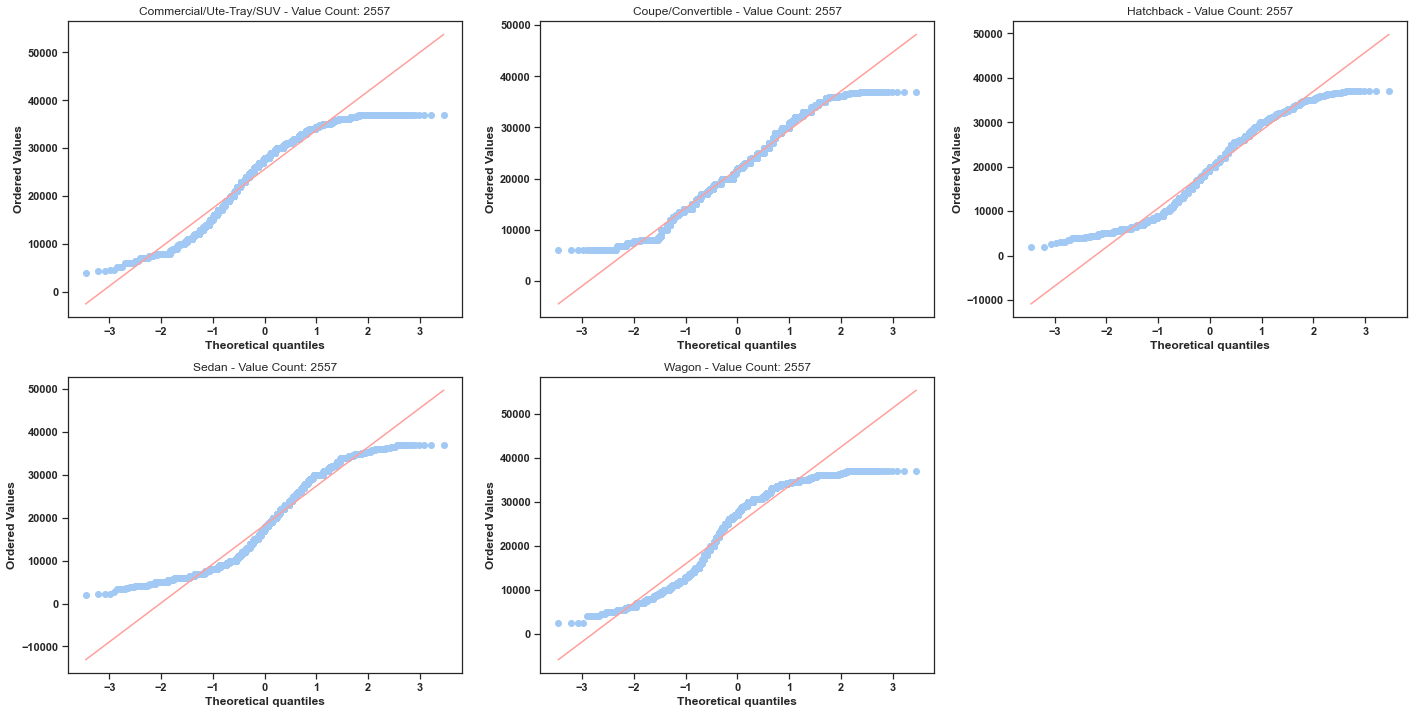

In [75]:
body_stat.residual_distribution()

___
#### <center> Homogenity of Variance Among Groups

<center> Is our assumption of Homoscedasticity violed?
    
___    

Using the Levene test to check the Homogeneity of variances.

The pvalue (1.1290339892475562e-49) is significant allowing us to conclude that types of Body have unequal variance


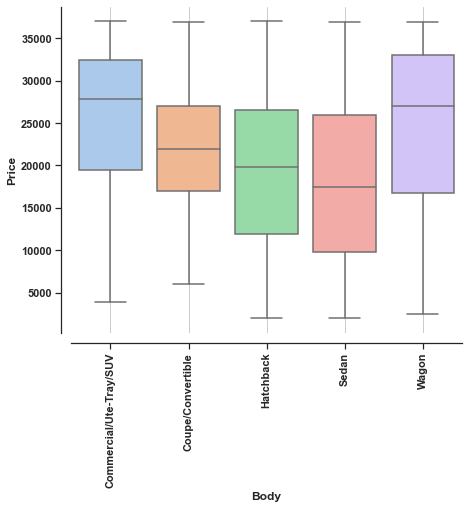

In [76]:
body_stat.Homogenity_of_Variance()

___
#### <center> Using the Kruskal-Wallis Test (Nonparametric) instead of a One-Way Anova as assumptions violated
    
___

In [77]:
body_stat.kruskal()

The p-value obtained from Kruskal-Wallis analysis is significant 1.1901557267690434e-265

We reject the null hypothesis and conclude that there is a statistically significant difference among the mean price of Body types.

                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
         group1               group2       meandiff  p-adj    lower      upper    reject
----------------------------------------------------------------------------------------
Commercial/Ute-Tray/SUV Coupe/Convertible -3758.8025  0.001 -4425.6655 -3091.9395   True
Commercial/Ute-Tray/SUV         Hatchback -6162.6515  0.001 -6829.5145 -5495.7886   True
Commercial/Ute-Tray/SUV             Sedan -7291.8709  0.001 -7958.7339  -6625.008   True
Commercial/Ute-Tray/SUV             Wagon   -914.632 0.0017  -1581.495   -247.769   True
      Coupe/Convertible         Hatchback  -2403.849  0.001  -3070.712 -1736.9861   True
      Coupe/Convertible             Sedan -3533.0684  0.001 -4199

___
## <center> Transmission
<center> Is there statistically significant difference between the mean price of different Transmission's at a significance level of 95%?

___
$$$$
**Null hypothesis:** Group means are equal
$$$$
**Alternative hypothesis:** At least, one group mean is different from other groups
___
    
**Non-Parametric Test:** Kruskal-Wallis   
    
**Level of Significance:** 0.05
    
___
    
#### <center> At first instance groups mean prices differ
    
<center> Transmission groups exhibit an imbalance (Unbalanced Design) indicating a general loss of statistical power. We will be using a Bootstrapped dataset statified by our Transmission variable to ensure we obtain an equal balance.

___    

In [78]:
transmission_stat = statistical_testing(new_filtered_car,'Transmission','Price')
transmission_stat.price_differential()

,mean,count
Transmission,,
Automatic,"23,132","9,759"
Manual,"17,611","1,483"


In [79]:
transmission_stat.price_differential(bootstraped=True)

Transmission Stratified Bootsraped With Replacement


,mean,count
Transmission,,
Automatic,"23,030","5,621"
Manual,"17,669","5,621"


___
#### <center> Non-Normality of Our Data
    
___    

Using the Shapiro-Wilk test.

The pvalue (5.377017259390097e-31) is significant allowing us to conclude the data is likely drawn from a non-normal distribution.

Additionally, the QQ plots below show a clear divergence from the diagonal line.


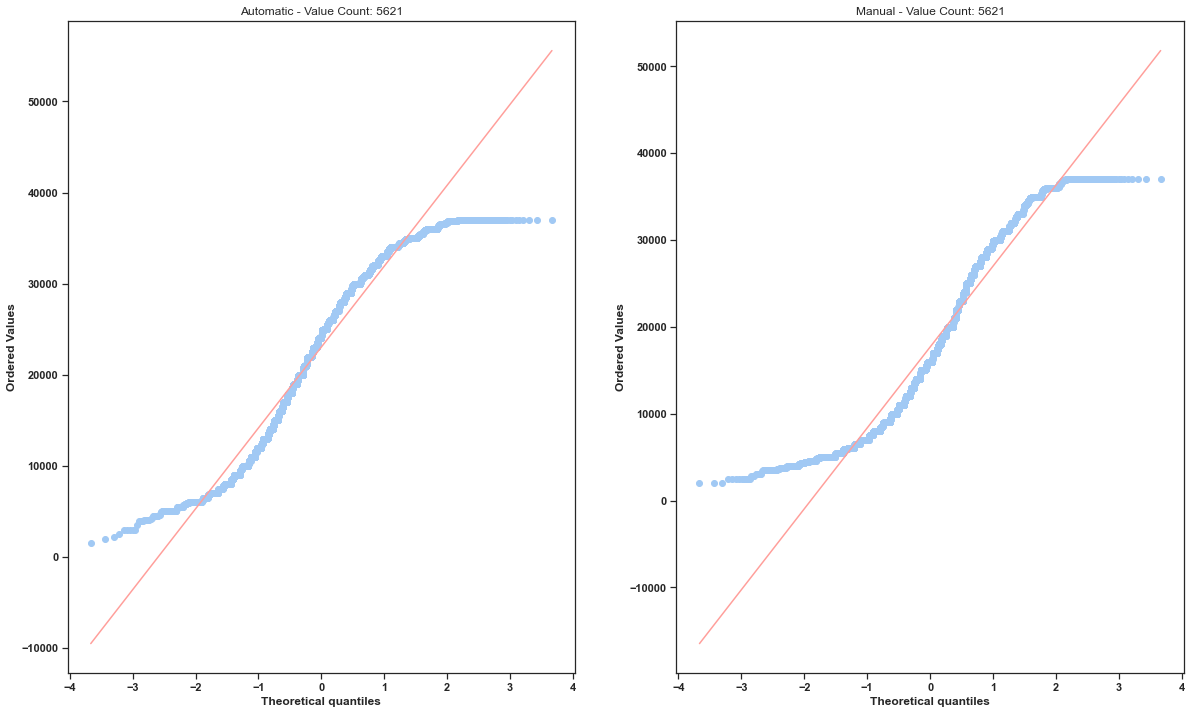

In [80]:
transmission_stat.residual_distribution()

___
#### <center> Homogenity of Variance Among Groups

<center> Is our assumption of Homoscedasticity violed?
    
___    

Using the Levene test to check the Homogeneity of variances.

The pvalue (5.828872081045591e-05) is significant allowing us to conclude that types of Transmission have unequal variance


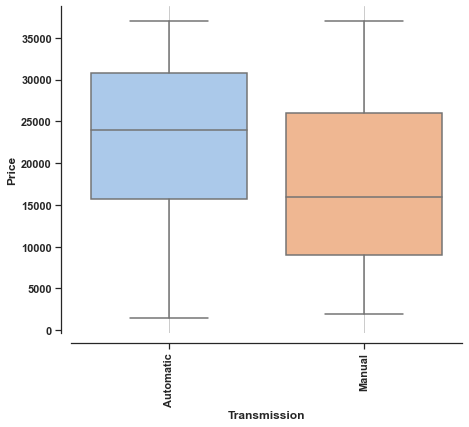

In [81]:
transmission_stat.Homogenity_of_Variance()

___
#### <center> Using the Kruskal-Wallis Test (Nonparametric) instead of a One-Way Anova as assumptions violated
    
___

In [82]:
transmission_stat.kruskal()

The p-value obtained from Kruskal-Wallis analysis is significant 8.43806837651857e-186

We reject the null hypothesis and conclude that there is a statistically significant difference among the mean price of Transmission types.



___
## <center> Drive
<center> Is there statistically significant difference between the mean price of different Drive's at a significance level of 95%?

___
$$$$
**Null hypothesis:** Group means are equal
$$$$
**Alternative hypothesis:** At least, one group mean is different from other groups
___
    
**Non-Parametric Test:** Kruskal-Wallis   
    
**Level of Significance:** 0.05
    
___
    
#### <center> At first instance groups mean prices differ
    
<center> Drive groups exhibit an imbalance (Unbalanced Design) indicating a general loss of statistical power. However, sample sizes are failry large. We will be using a Bootstrapped dataset statified by our Drive variable to ensure we obtain an equal balance.

___    

In [83]:
drive_stat = statistical_testing(new_filtered_car,'Drive','Price')
drive_stat.price_differential()

,mean,count
Drive,,
AWD,"24,502","1,034"
4WD/Front,"22,405","8,408"
Rear,"21,193","1,800"


In [84]:
drive_stat.price_differential(bootstraped=True)

Drive Stratified Bootsraped With Replacement


,mean,count
Drive,,
AWD,"24,390","4,721"
4WD/Front,"22,364","4,721"
Rear,"21,300","4,721"


___
#### <center> Non-Normality of Our Data
    
___    

Using the Shapiro-Wilk test.

The pvalue (2.031571644654509e-35) is significant allowing us to conclude the data is likely drawn from a non-normal distribution.

Additionally, the QQ plots below show a clear divergence from the diagonal line.


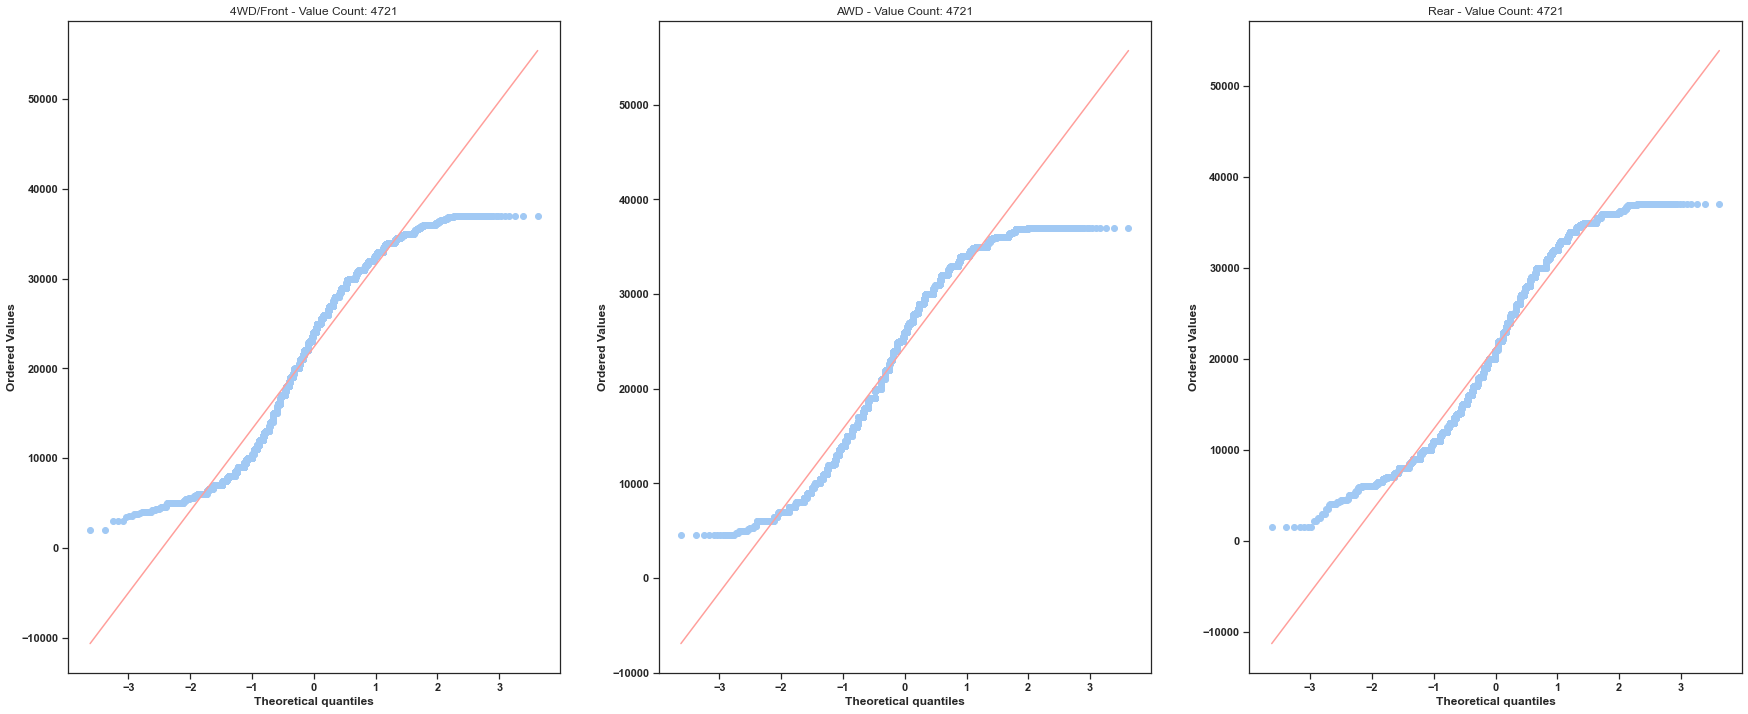

In [85]:
drive_stat.residual_distribution()

___
#### <center> Homogenity of Variance Among Groups

<center> Is our assumption of Homoscedasticity violed?
    
___    

Using the Levene test to check the Homogeneity of variances.

The pvalue (1.1010002969128548e-06) is significant allowing us to conclude that types of Drive have unequal variance


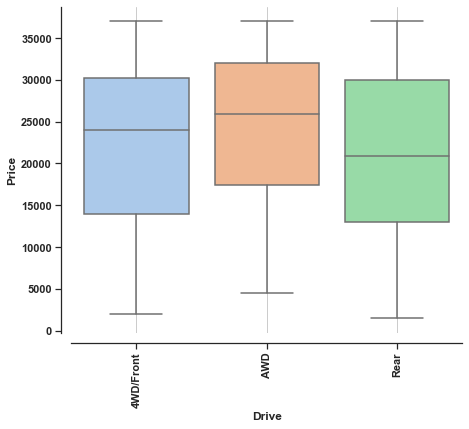

In [86]:
drive_stat.Homogenity_of_Variance()

___
#### <center> Using the Kruskal-Wallis Test (Nonparametric) instead of a One-Way Anova as assumptions violated
    
___

In [87]:
drive_stat.kruskal()

The p-value obtained from Kruskal-Wallis analysis is significant 3.414816381721232e-59

We reject the null hypothesis and conclude that there is a statistically significant difference among the mean price of Drive types.

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1  group2  meandiff  p-adj   lower      upper   reject
-------------------------------------------------------------
4WD/Front    AWD  2026.4461 0.001  1584.4281 2468.4641   True
4WD/Front   Rear -1064.3169 0.001 -1506.3349 -622.2989   True
      AWD   Rear  -3090.763 0.001  -3532.781 -2648.745   True
-------------------------------------------------------------
We fail to reject 0 and reject 3

We would thus conclude that there is a statistically significant difference
between the 3 pairwise mean comparisons of Drive type groups


___
## <center> Fuel Type
<center> Is there statistically significant difference between the mean price of different Fuel Type's at a significance level of 95%?

___
$$$$
**Null hypothesis:** Group means are equal
$$$$
**Alternative hypothesis:** At least, one group mean is different from other groups
___
    
**Non-Parametric Test:** Kruskal-Wallis   
    
**Level of Significance:** 0.05
    
___
    
#### <center> At first instance groups mean prices differ
    
<center> Fuel Type groups exhibit an imbalance (Unbalanced Design) indicating a general loss of statistical power. We will be using a Bootstrapped dataset statified by our Fuel Type variable to ensure we obtain an equal balance.

___    

In [88]:
fuel_stat = statistical_testing(new_filtered_car,'Fuel_type','Price')
fuel_stat.price_differential()

,mean,count
Fuel_type,,
Hybrid,"30,039",216
Diesel/Premium,"24,864","4,123"
Unleaded,"20,772","6,815"
LPG,"14,789",88


In [89]:
fuel_stat.price_differential(bootstraped=True)

Fuel_type Stratified Bootsraped With Replacement


,mean,count
Fuel_type,,
Hybrid,"29,986","3,451"
Diesel/Premium,"24,995","3,451"
Unleaded,"20,597","3,451"
LPG,"14,826","3,451"


___
#### <center> Non-Normality of Our Data
    
___    

Using the Shapiro-Wilk test.

The pvalue (1.0326921338465328e-13) is significant allowing us to conclude the data is likely drawn from a non-normal distribution.

Additionally, the QQ plots below show a clear divergence from the diagonal line.


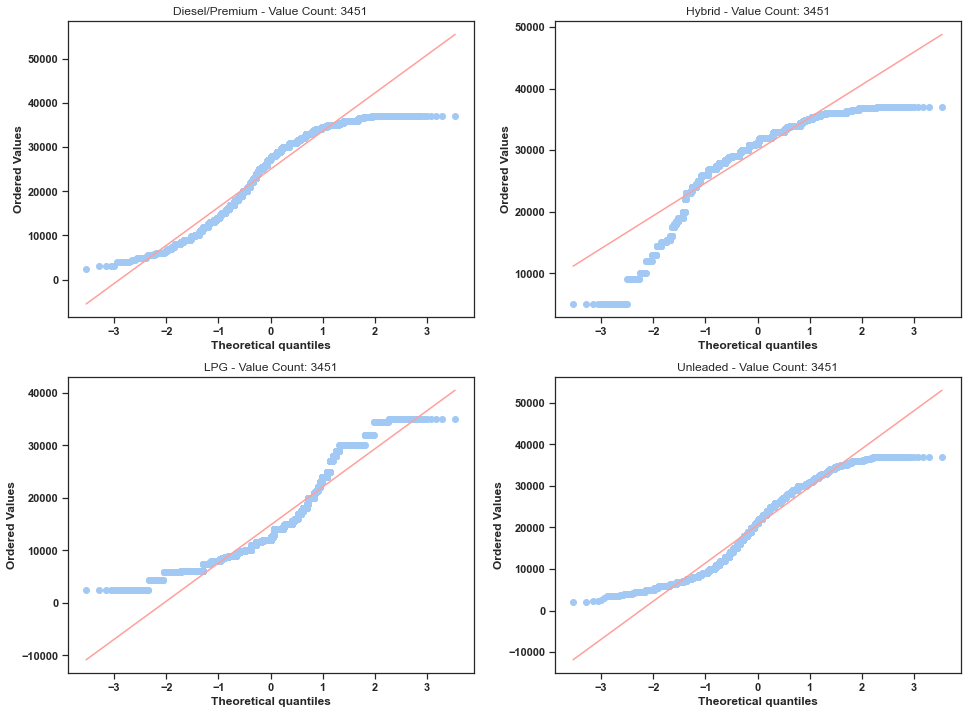

In [90]:
fuel_stat.residual_distribution()

___
#### <center> Homogenity of Variance Among Groups

<center> Is our assumption of Homoscedasticity violed?
    
___    

Using the Levene test to check the Homogeneity of variances.

The pvalue (5.830980615714704e-293) is significant allowing us to conclude that types of Fuel_type have unequal variance


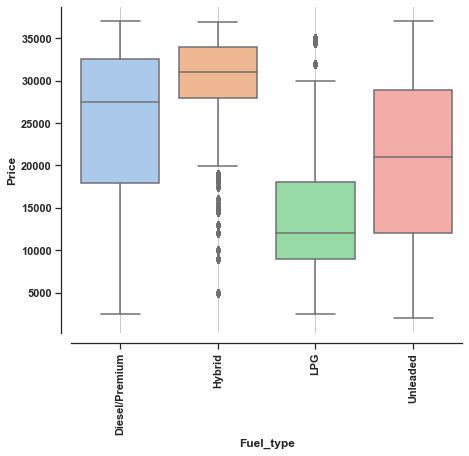

In [91]:
fuel_stat.Homogenity_of_Variance()

___
#### <center> Using the Kruskal-Wallis Test (Nonparametric) instead of a One-Way Anova as assumptions violated
    
___

In [92]:
fuel_stat.kruskal()

The p-value obtained from Kruskal-Wallis analysis is significant 0.0

We reject the null hypothesis and conclude that there is a statistically significant difference among the mean price of Fuel_type types.

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1      group2    meandiff  p-adj    lower       upper    reject
------------------------------------------------------------------------
Diesel/Premium   Hybrid   4990.2304 0.001   4492.1144   5488.3463   True
Diesel/Premium      LPG -10169.3637 0.001 -10667.4796  -9671.2477   True
Diesel/Premium Unleaded  -4398.0742 0.001  -4896.1901  -3899.9582   True
        Hybrid      LPG  -15159.594 0.001   -15657.71 -14661.4781   True
        Hybrid Unleaded  -9388.3045 0.001  -9886.4205  -8890.1886   True
           LPG Unleaded   5771.2895 0.001   5273.1735   6269.4054   True
------------------------------------------------------------------------
We fail to reject 0 and reject 6

We would thus conclude that 

___
### <center> Investigating cardinality

<center> We refer to the number of unique entries of a categorical variable as the cardinality of that categorical variable.
    
___

In [111]:
# All categorical columns
object_cols = [col for col in new_filtered_car.columns if new_filtered_car[col].dtype == 'object']

# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: new_filtered_car[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
print(sorted(d.items(), key=lambda x: x[1],reverse=True))

# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if new_filtered_car[col].nunique() <= 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('\nCategorical columns that will be dummy encoded:', low_cardinality_cols)
print("\nNumerical columns that will be used in the model: ['Age', 'Engine_Durability']")



[('Model', 8), ('Body', 5), ('Fuel_type', 4), ('Drive', 3), ('Transmission', 2)]

Categorical columns that will be dummy encoded: ['Model', 'Body', 'Transmission', 'Drive', 'Fuel_type']

Numerical columns that will be used in the model: ['Age', 'Engine_Durability']


___
### <center> Dummy Encoding Categorical Columns
___

In [ ]:
final_df = pd.get_dummies(data = new_filtered_car, drop_first = True)
#final_df.to_csv('ModellingNewCarSales_Web.csv',index=False)  

___
### <center> Avoiding Data Leakage
<center> We will normalize our data after performing train-test split to avoid Data Leakage. Normalization is performed for all models using the StandardScaler() module within our Pipeline.
    
___

___
## <center> Data Modeling
___
### <center> Random Forest Regressor Model  

In [232]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

step =[('scaler', StandardScaler()),
       ('RF', RandomForestRegressor(random_state = 1,
                                    n_estimators = 100,
                                    max_depth = 12,   
                                    min_samples_leaf = 2))]

RF_pipeline = Pipeline(step)


### <center> Random Forest Regressor Model With PCA   

In [234]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

step =[('scaler', StandardScaler()),
       ('PCA', PCA( 
                  whiten=True, 
                  random_state=42)),
       ('RF', RandomForestRegressor(random_state = 1,
                                    n_estimators = 100,
                                    max_depth = 12,   
                                    min_samples_leaf = 2))]

PCA_pipeline = Pipeline(step)

___
## <center> Splitting the dataset into training and validation
    
___

In [223]:
# Create X,y variables
X = final_df.drop(['Price'],axis =1).values
y = final_df['Price'].values

# Split Data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=77)
print('Training dataset: X_train=', X_train.shape, ', y_train', y_train.shape)
print('\nTesting dataset: X_test=', X_test.shape, ', y_test', y_test.shape)

Training dataset: X_train= (8431, 19) , y_train (8431,)

Testing dataset: X_test= (2811, 19) , y_test (2811,)


___
### <center> Hyper-Parameter Tunning
___

In [237]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)

steps =[('scaler', StandardScaler()),
       ('RF', RandomForestRegressor(random_state=42))]

tunned_RF_pipeline = Pipeline(steps)

# Create the parameter grid
rf_param_grid = {
    'RF__n_estimators' : [200,300,400,500],
    'RF__max_features' : ["sqrt","auto"],
    'RF__min_samples_split':[3,5,6],
    'RF__max_depth' : [10,15,20],
}

# Perform RandomizedSearchCV
grid_RF = RandomizedSearchCV(estimator=tunned_RF_pipeline,
                             param_distributions = rf_param_grid,
                             n_jobs = -1,
                             scoring = 'neg_mean_squared_error',
                             cv=cv_inner, 
                             verbose=1,
                            refit=True)

# configure the cross-validation procedure
grid_RF.fit(X_train,y_train)

print("Best parameters found: ", grid_RF.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.9s finished


Best parameters found:  {'RF__n_estimators': 400, 'RF__min_samples_split': 3, 'RF__max_features': 'sqrt', 'RF__max_depth': 15}


___
### <center> Hyper-Parameter Tunning with PCA
___

In [244]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)

steps =[('scaler', StandardScaler()),
        ('PCA', PCA( 
                  whiten=True, 
                  random_state=42)),
       ('RF', RandomForestRegressor(random_state=42))]

tunned_PCA_pipeline = Pipeline(steps)

# Create the parameter grid
PCA_param_grid = {
    'RF__n_estimators' : [300,400,500],
    'RF__max_features' : ["sqrt","auto"],
    'RF__min_samples_split':[2,5,6],
    'RF__max_depth' : [10,15,20],
    'PCA__n_components':[15,18,22],
}

# Perform RandomizedSearchCV
PCA_grid_RF = RandomizedSearchCV(estimator=tunned_PCA_pipeline,
                             param_distributions = PCA_param_grid,
                             n_jobs = -1,
                             scoring = 'neg_mean_squared_error',
                             cv=cv_inner, 
                             verbose=1,
                            refit=True)

# configure the cross-validation procedure
PCA_grid_RF.fit(X_train,y_train)

print("Best parameters found: ", PCA_grid_RF.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.1s finished


Best parameters found:  {'RF__n_estimators': 300, 'RF__min_samples_split': 5, 'RF__max_features': 'sqrt', 'RF__max_depth': 15, 'PCA__n_components': 18}


___
## <center> Model Performance – Evaluation
___

In [239]:
# Fitting the model
RF_pipeline.fit(X_train, y_train)

# Establishing a baseline
baseline = np.mean(y)
y_baseline = np.repeat(baseline, len(y_test))

# Establishing baseline root/mean-squared-error
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(mean_squared_error(y_test, y_baseline))

# Prediction in the training dataset
y_train_pred = RF_pipeline.predict(X_train)

# Prediction in the testing dataset 
y_test_pred = RF_pipeline.predict(X_test)

# Establishing model mean-squared-error
MSE_training = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

# Establishing model root-mean-squared-error
RMSE_training = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test=np.sqrt(mean_squared_error(y_test, y_test_pred))


print('The naive MSE baseline is ', naive_MSE)
print('The naive RMSE baseline is ', naive_RMSE)
print(f'\nThe model performance in training for MSE: {MSE_training}')
print(f'The model performance in training for RMSE: {RMSE_training}')
print(f'\nThe model performance in testing for MSE: {MSE_test}')
print(f'The model performance in training for RMSE: {RMSE_test}')

The naive MSE baseline is  86737755.56235546
The naive RMSE baseline is  9313.31066604972

The model performance in training for MSE: 8798101.14108254
The model performance in training for RMSE: 2966.1593249659636

The model performance in testing for MSE: 13835176.14844678
The model performance in training for RMSE: 3719.566661379626


___
## <center> PCA Model Performance – Evaluation
___

In [240]:
# Fitting the model
PCA_pipeline.fit(X_train, y_train)

# Establishing a baseline
baseline = np.mean(y)
y_baseline = np.repeat(baseline, len(y_test))

# Establishing baseline root/mean-squared-error
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(mean_squared_error(y_test, y_baseline))

# Prediction in the training dataset
y_train_pred = PCA_pipeline.predict(X_train)

# Prediction in the testing dataset 
y_test_pred = PCA_pipeline.predict(X_test)

# Establishing model mean-squared-error
MSE_training = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

# Establishing model root-mean-squared-error
RMSE_training = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test=np.sqrt(mean_squared_error(y_test, y_test_pred))


print('The naive MSE baseline is ', naive_MSE)
print('The naive RMSE baseline is ', naive_RMSE)
print(f'\nThe model performance in training for MSE: {MSE_training}')
print(f'The model performance in training for RMSE: {RMSE_training}')
print(f'\nThe model performance in testing for MSE: {MSE_test}')
print(f'The model performance in training for RMSE: {RMSE_test}')


The naive MSE baseline is  86737755.56235546
The naive RMSE baseline is  9313.31066604972

The model performance in training for MSE: 7124135.77961897
The model performance in training for RMSE: 2669.1076747892675

The model performance in testing for MSE: 12990595.132787948
The model performance in training for RMSE: 3604.246819071628


___
## <center> Tunned Model Performance – Evaluation
___

In [241]:
# Establishing a baseline
baseline = np.mean(y)
y_baseline = np.repeat(baseline, len(y_test))

# Establishing baseline root/mean-squared-error
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(mean_squared_error(y_test, y_baseline))

# Prediction in the training dataset
y_train_pred = grid_RF.predict(X_train)

# Prediction in the testing dataset 
y_test_pred = grid_RF.predict(X_test)

# Establishing model mean-squared-error
MSE_training = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

# Establishing model root-mean-squared-error
RMSE_training = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test=np.sqrt(mean_squared_error(y_test, y_test_pred))


print('The naive MSE baseline is ', naive_MSE)
print('The naive RMSE baseline is ', naive_RMSE)
print(f'\nThe model performance in training for MSE: {MSE_training}')
print(f'The model performance in training for RMSE: {RMSE_training}')
print(f'\nThe model performance in testing for MSE: {MSE_test}')
print(f'The model performance in training for RMSE: {RMSE_test}')

The naive MSE baseline is  86737755.56235546
The naive RMSE baseline is  9313.31066604972

The model performance in training for MSE: 7394794.260121337
The model performance in training for RMSE: 2719.337099390463

The model performance in testing for MSE: 12728273.695832208
The model performance in training for RMSE: 3567.6706260292876


___
## <center> PCA Tunned Model Performance – Evaluation
___

In [245]:
# Establishing a baseline
baseline = np.mean(y)
y_baseline = np.repeat(baseline, len(y_test))

# Establishing baseline root/mean-squared-error
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(mean_squared_error(y_test, y_baseline))

# Prediction in the training dataset
y_train_pred = PCA_grid_RF.predict(X_train)

# Prediction in the testing dataset 
y_test_pred = PCA_grid_RF.predict(X_test)

# Establishing model mean-squared-error
MSE_training = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

# Establishing model root-mean-squared-error
RMSE_training = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test=np.sqrt(mean_squared_error(y_test, y_test_pred))


print('The naive MSE baseline is ', naive_MSE)
print('The naive RMSE baseline is ', naive_RMSE)
print(f'\nThe model performance in training for MSE: {MSE_training}')
print(f'The model performance in training for RMSE: {RMSE_training}')
print(f'\nThe model performance in testing for MSE: {MSE_test}')
print(f'The model performance in training for RMSE: {RMSE_test}')

The naive MSE baseline is  86737755.56235546
The naive RMSE baseline is  9313.31066604972

The model performance in training for MSE: 6423357.3515401445
The model performance in training for RMSE: 2534.434325750057

The model performance in testing for MSE: 12703049.691412088
The model performance in training for RMSE: 3564.1337925801954


___
## <center> Model Performance – Plotting
___

<AxesSubplot:xlabel='true', ylabel='predicted'>

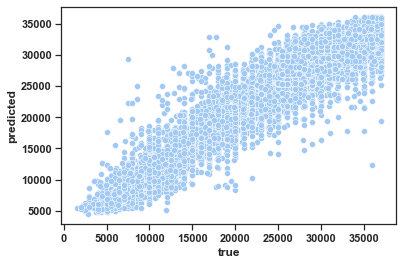

In [246]:
plotting_df = pd.DataFrame()
plotting_df['predicted'] = PCA_grid_RF.predict(X)
plotting_df['true'] = y
sns.scatterplot(x = 'true', y = 'predicted', data = plotting_df)